# Representation Learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score, roc_curve, precision_recall_curve
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split

### Q3.1 Pretraining and Linear Probes (4 pts)

### Used transformer architecture similar to Q2.2 implementation

In [2]:
from torch.utils.data import DataLoader, Dataset
class PatientDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
batch_size = 64

# Training Data
df = pd.read_parquet('final-data/final-set-a.parquet')
X_a = df.fillna(0)
X_a = X_a.groupby("RecordID").tail(49).reset_index(drop=True)
X_a = X_a.sort_values(by="RecordID", ascending=True)
X_a["Time"] = scaler.fit_transform(X_a[["Time"]])
X_a = X_a.drop(columns=["RecordID"]).drop(columns=["MechVent"])
X_a = X_a[sorted(X_a.columns)]
X_a = X_a.to_numpy()
X_a = X_a.reshape(4000,49,40)

train_dataset = PatientDataset(X_a, X_a)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data
df = pd.read_parquet('final-data/final-set-b.parquet')
X_b = df.fillna(0)
X_b = X_b.groupby("RecordID").tail(49).reset_index(drop=True)
X_b = X_b.sort_values(by="RecordID", ascending=True)
X_b["Time"] = scaler.fit_transform(X_b[["Time"]])
X_b = X_b.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_b = X_b[sorted(X_b.columns)]
X_b = X_b.to_numpy()
X_b = X_b.reshape(4000,49,40)

val_dataset = PatientDataset(X_b, X_b)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Test data
df = pd.read_parquet('final-data/final-set-c.parquet')
X_c = df.fillna(0)
X_c = X_c.groupby("RecordID").tail(49).reset_index(drop=True)
X_c = X_c.sort_values(by="RecordID", ascending=True)
X_c["Time"] = scaler.fit_transform(X_c[["Time"]])
X_c = X_c.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_c = X_c[sorted(X_c.columns)]
X_c = X_c.to_numpy()
X_c = X_c.reshape(4000,49,40)

test_dataset = PatientDataset(X_c, X_c)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Transformer from Q2.3a without FC layer for classification

class TransformerEncoder(nn.Module):
    def __init__(self, input_size=40, latent_dim=16, seq_length=49, num_heads=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.embedding = nn.Linear(input_size, latent_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,  # Dimensionality of the embeddings
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        
        # Stacking multiple transformer layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

In [5]:
# Decoder to decode latent space data to original space

class TransformerDecoder(nn.Module):
    def __init__(self, output_dim=40, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerDecoder, self).__init__()

        self.input_layer = nn.Linear(latent_dim, latent_dim)
        self.output_layer = nn.Linear(latent_dim, output_dim)
        
        # Use latent_dim for the decoder layers
        decoder_layers = nn.TransformerDecoderLayer(d_model=latent_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        
    def forward(self, latent, memory=None):
        x_reconstructed = self.input_layer(latent)  # Project back to latent_dim
        x_reconstructed = self.decoder(x_reconstructed, memory)  # Transformer decoder
        x_reconstructed = self.output_layer(x_reconstructed)  # Project back to original input_dim (output_dim)
        return x_reconstructed

In [6]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=40, seq_length=49, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim=latent_dim, seq_length=seq_length, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
        self.decoder = TransformerDecoder(output_dim=input_dim, latent_dim=latent_dim, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
    
    def forward(self, x):
        latent = self.encoder(x)  # Get the latent representation from the encoder
        x_reconstructed = self.decoder(latent, latent)  # Pass latent to the decoder
        return x_reconstructed, latent

100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch 1/25, Train Loss: 0.681492, Val Loss: 0.848409


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


Epoch 2/25, Train Loss: 0.538077, Val Loss: 0.764947


100%|██████████| 63/63 [00:12<00:00,  4.93it/s]


Epoch 3/25, Train Loss: 0.471586, Val Loss: 0.714213


100%|██████████| 63/63 [00:13<00:00,  4.68it/s]


Epoch 4/25, Train Loss: 0.430281, Val Loss: 0.681320


100%|██████████| 63/63 [00:10<00:00,  5.79it/s]


Epoch 5/25, Train Loss: 0.402119, Val Loss: 0.654211


100%|██████████| 63/63 [00:10<00:00,  6.05it/s]


Epoch 6/25, Train Loss: 0.375832, Val Loss: 0.631008


100%|██████████| 63/63 [00:11<00:00,  5.55it/s]


Epoch 7/25, Train Loss: 0.353423, Val Loss: 0.610252


100%|██████████| 63/63 [00:11<00:00,  5.56it/s]


Epoch 8/25, Train Loss: 0.332400, Val Loss: 0.590500


100%|██████████| 63/63 [00:11<00:00,  5.27it/s]


Epoch 9/25, Train Loss: 0.314669, Val Loss: 0.575689


100%|██████████| 63/63 [00:13<00:00,  4.79it/s]


Epoch 10/25, Train Loss: 0.301502, Val Loss: 0.563354


100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


Epoch 11/25, Train Loss: 0.287873, Val Loss: 0.552085


100%|██████████| 63/63 [00:10<00:00,  6.05it/s]


Epoch 12/25, Train Loss: 0.278743, Val Loss: 0.543956


100%|██████████| 63/63 [00:10<00:00,  5.99it/s]


Epoch 13/25, Train Loss: 0.269521, Val Loss: 0.539152


100%|██████████| 63/63 [00:09<00:00,  6.55it/s]


Epoch 14/25, Train Loss: 0.264295, Val Loss: 0.531934


100%|██████████| 63/63 [00:10<00:00,  6.27it/s]


Epoch 15/25, Train Loss: 0.257177, Val Loss: 0.527510


100%|██████████| 63/63 [00:09<00:00,  6.46it/s]


Epoch 16/25, Train Loss: 0.253296, Val Loss: 0.523388


100%|██████████| 63/63 [00:09<00:00,  6.65it/s]


Epoch 17/25, Train Loss: 0.248621, Val Loss: 0.519737


100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 18/25, Train Loss: 0.245014, Val Loss: 0.517691


100%|██████████| 63/63 [00:09<00:00,  6.57it/s]


Epoch 19/25, Train Loss: 0.241863, Val Loss: 0.515575


100%|██████████| 63/63 [00:10<00:00,  6.02it/s]


Epoch 20/25, Train Loss: 0.240780, Val Loss: 0.513703


100%|██████████| 63/63 [00:10<00:00,  6.29it/s]


Epoch 21/25, Train Loss: 0.237669, Val Loss: 0.512507


100%|██████████| 63/63 [00:09<00:00,  6.63it/s]


Epoch 22/25, Train Loss: 0.235899, Val Loss: 0.510819


100%|██████████| 63/63 [00:09<00:00,  6.59it/s]


Epoch 23/25, Train Loss: 0.234671, Val Loss: 0.509839


100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Epoch 24/25, Train Loss: 0.233351, Val Loss: 0.508764


100%|██████████| 63/63 [00:09<00:00,  6.37it/s]


Epoch 25/25, Train Loss: 0.232779, Val Loss: 0.508339


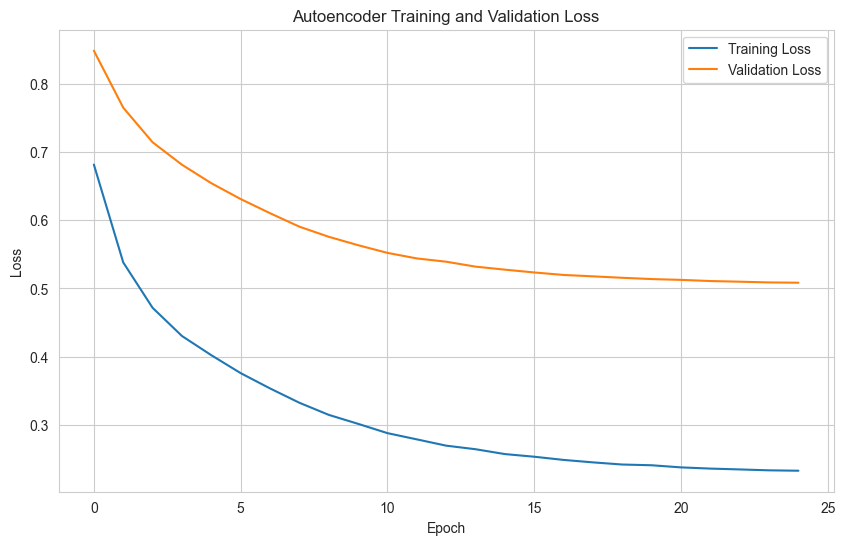

<All keys matched successfully>

In [17]:
# Initialize model and optimization
hidden_dim = 128
autoencoder = TransformerAutoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 25
train_losses = []
val_losses = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

if not os.path.exists("embedding_autoencoder_transformer"):
        os.makedirs("embedding_autoencoder_transformer")


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'embedding_autoencoder_transformer/best_autoencoder_transformer.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/autoencoder_loss_transformer.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('embedding_autoencoder_transformer/best_autoencoder_transformer.pth'))

### Linear Probe

In [34]:
# Takes input data as tensor and returns embeddings (e.g., 4000x49x40 => 4000x16)
def create_embeddings(input_data, model, device='cuda'):
    model.eval()
    input_data = input_data.to(device)
    with torch.no_grad():
        latent_embeddings = model.encoder(input_data)
    embeddings = latent_embeddings.mean(dim=1)  #mean of all time stamps
    #embeddings = latent_embeddings[:, -1, :]   #last time stamp at 48h, different approach
    
    return embeddings

In [35]:
# Take embeddings and load labels
X_a_tensor = torch.tensor(X_a, dtype=torch.float32)
X_train = create_embeddings(X_a_tensor, autoencoder, 'cpu')
print(X_train.shape)
X_train = X_train.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-a.parquet')
y_train = y_df["In-hospital_death"].to_numpy().flatten()

X_b_tensor = torch.tensor(X_b, dtype=torch.float32)
X_val = create_embeddings(X_b_tensor, autoencoder, 'cpu')
X_val = X_val.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-b.parquet')
y_val = y_df["In-hospital_death"].to_numpy().flatten()

# Loading test set C
X_c_tensor = torch.tensor(X_c, dtype=torch.float32)
X_test = create_embeddings(X_c_tensor, autoencoder, 'cpu')
X_test = X_test.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-c.parquet')
y_test = y_df["In-hospital_death"].to_numpy().flatten()

torch.Size([4000, 16])


C=0.001, Validation AuROC: 0.7729, Validation AuPRC: 0.3737
C=0.01, Validation AuROC: 0.7839, Validation AuPRC: 0.3864
C=0.1, Validation AuROC: 0.7864, Validation AuPRC: 0.3870
C=1, Validation AuROC: 0.7873, Validation AuPRC: 0.3891
C=10, Validation AuROC: 0.7879, Validation AuPRC: 0.3932
C=100, Validation AuROC: 0.7876, Validation AuPRC: 0.3943
Best validation AuROC: 0.7879
Test AuROC: 0.7902
Test AuPRC: 0.4143


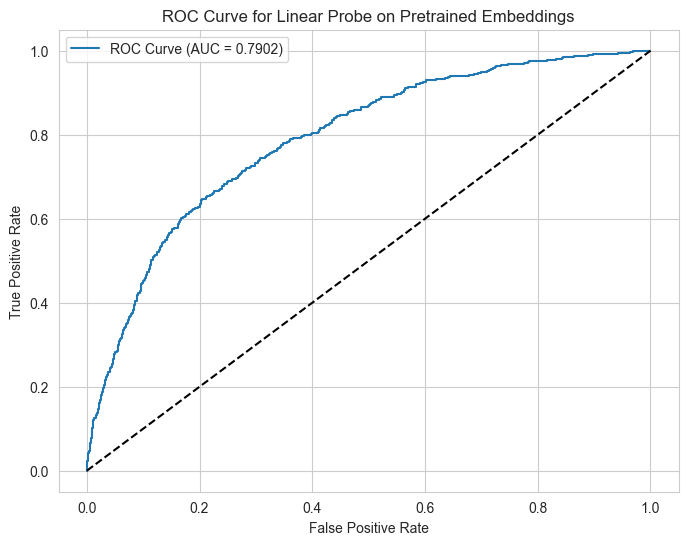

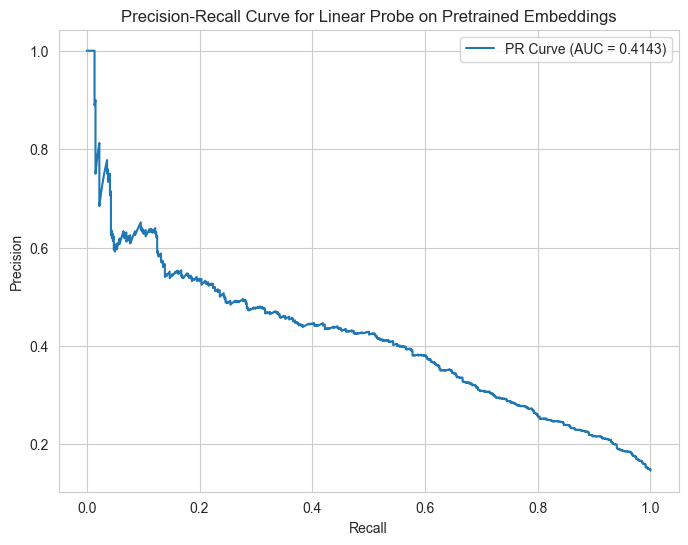

In [36]:
# Logistic Regression, try different regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_val_auc = 0
best_model = None

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_auprc = average_precision_score(y_val, val_probs)
    
    print(f"C={C}, Validation AuROC: {val_auc:.4f}, Validation AuPRC: {val_auprc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model

print(f"Best validation AuROC: {best_val_auc:.4f}")

# Evaluation on test set
# Make predictions
test_probs = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"Test AuROC: {test_auc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")


fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/roc_curve.png')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {test_auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/pr_curve.png')
plt.show()

### Q3.2 Simulate label scarcity (4 pts)

### Q3.2 Part i)

We train three different supervised models with the same (or as similar as possible) architecture as our pretrained network, but only use 100, 500, and 1000 patients from the training set and report our full test set performance (2 pts).

### Q3.2 Part ii)

We train three linear probes (as in Q3.1 step 2) using only 100, 500, 1000 labelled patients and report the full test set C performance (2 pts).

In [37]:
# Assuming we have
# - X_train, y_train: Test data embeddings and labels (from set A)
# - X_test, y_test: Test data embeddings and labels (from set C)
def train_linear_probe_sparse(X_train, y_train, X_test, y_test, n_samples):
    """
    Train a logistic regression model using only n_samples labeled examples
    """
    # Randomly sample n patients, we use stratified sampling to maintain class imbalance
    _, X_sampled, _, y_sampled = train_test_split(
        X_train, y_train, 
        test_size=n_samples/len(y_train),
        stratify=y_train,
        random_state=42
    )
        
    print(f"Training with {len(y_sampled)} samples")
    
    # Train logistic regression
    model = LogisticRegression(C=10.0, max_iter=1000, random_state=42)
    model.fit(X_sampled, y_sampled)
    
    # Evaluate on test set
    test_probs = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)
    test_auprc = average_precision_score(y_test, test_probs)
    
    return model, test_auc, test_auprc


Training with 100 labeled samples:
Training with 100 samples
Test AuROC: 0.7367
Test AuPRC: 0.3333

Training with 200 labeled samples:
Training with 200 samples
Test AuROC: 0.7645
Test AuPRC: 0.3759

Training with 300 labeled samples:
Training with 300 samples
Test AuROC: 0.7689
Test AuPRC: 0.3797

Training with 400 labeled samples:
Training with 400 samples
Test AuROC: 0.7771
Test AuPRC: 0.3921

Training with 500 labeled samples:
Training with 500 samples
Test AuROC: 0.7796
Test AuPRC: 0.4057

Training with 600 labeled samples:
Training with 600 samples
Test AuROC: 0.7833
Test AuPRC: 0.4049

Training with 700 labeled samples:
Training with 700 samples
Test AuROC: 0.7854
Test AuPRC: 0.4045

Training with 800 labeled samples:
Training with 800 samples
Test AuROC: 0.7832
Test AuPRC: 0.3977

Training with 900 labeled samples:
Training with 900 samples
Test AuROC: 0.7842
Test AuPRC: 0.4042

Training with 1000 labeled samples:
Training with 1000 samples
Test AuROC: 0.7818
Test AuPRC: 0.402

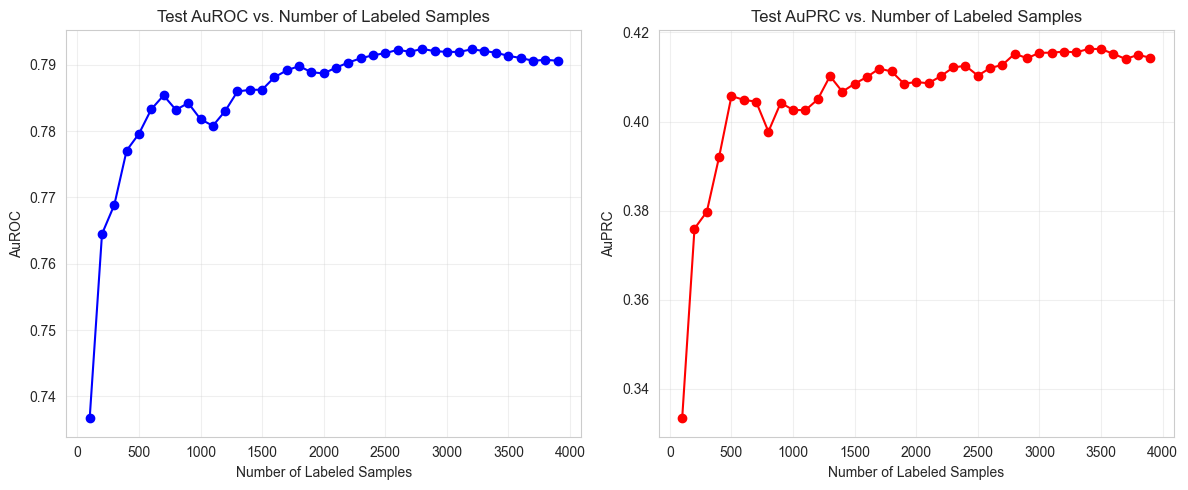

In [38]:
# Sample sizes to evaluate
sample_sizes = list(range(100, 4000, 100))
results = []

# Train and evaluate for each sample size
for n in sample_sizes:
    print(f"\nTraining with {n} labeled samples:")
    _, auc, auprc = train_linear_probe_sparse(X_train, y_train, X_test, y_test, n)
    
    print(f"Test AuROC: {auc:.4f}")
    print(f"Test AuPRC: {auprc:.4f}")
    
    results.append({
        'n_samples': n,
        'AuROC': auc,
        'AuPRC': auprc
    })
results_df = pd.DataFrame(results)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_samples'], results_df['AuROC'], 'o-', color='blue')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuROC')
plt.title('Test AuROC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_samples'], results_df['AuPRC'], 'o-', color='red')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuPRC')
plt.title('Test AuPRC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/limited_labels_performance.png', dpi=300)
plt.show()

### Q3.3: Visualising Learned Representations (4 Pts)

We visualize the patient representations of the representation / latent space in two dimensions using t-SNE. 

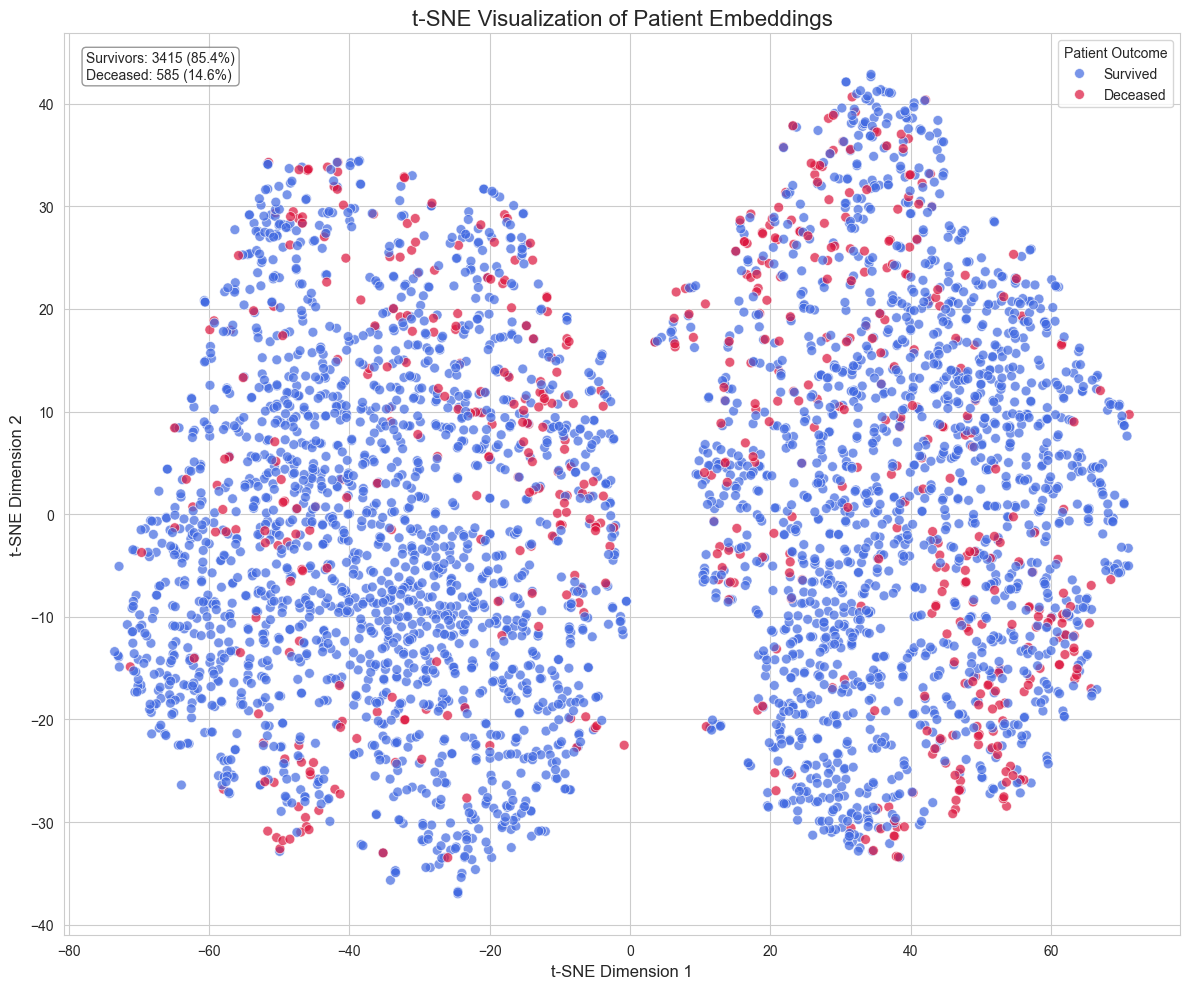

In [40]:
#Visualization of test set only
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

# Convert PyTorch tensors to NumPy arrays
X_test_np = X_test.cpu().numpy()  # Move to CPU if on GPU and convert to NumPy
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Fit t-SNE
X_tsne = tsne.fit_transform(X_test_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'label': y_test_np
})

tsne_df['label'] = tsne_df['label'].astype('category')

# Plot with different colors for labels 0 or 1
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

survivors = (y_test_np == 0).sum()
deceased = (y_test_np == 1).sum()
total = len(y_test_np)

plt.annotate(f'Survivors: {survivors} ({survivors/total:.1%})\nDeceased: {deceased} ({deceased/total:.1%})',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/tsne_visualization_test.png', dpi=300)
plt.show()

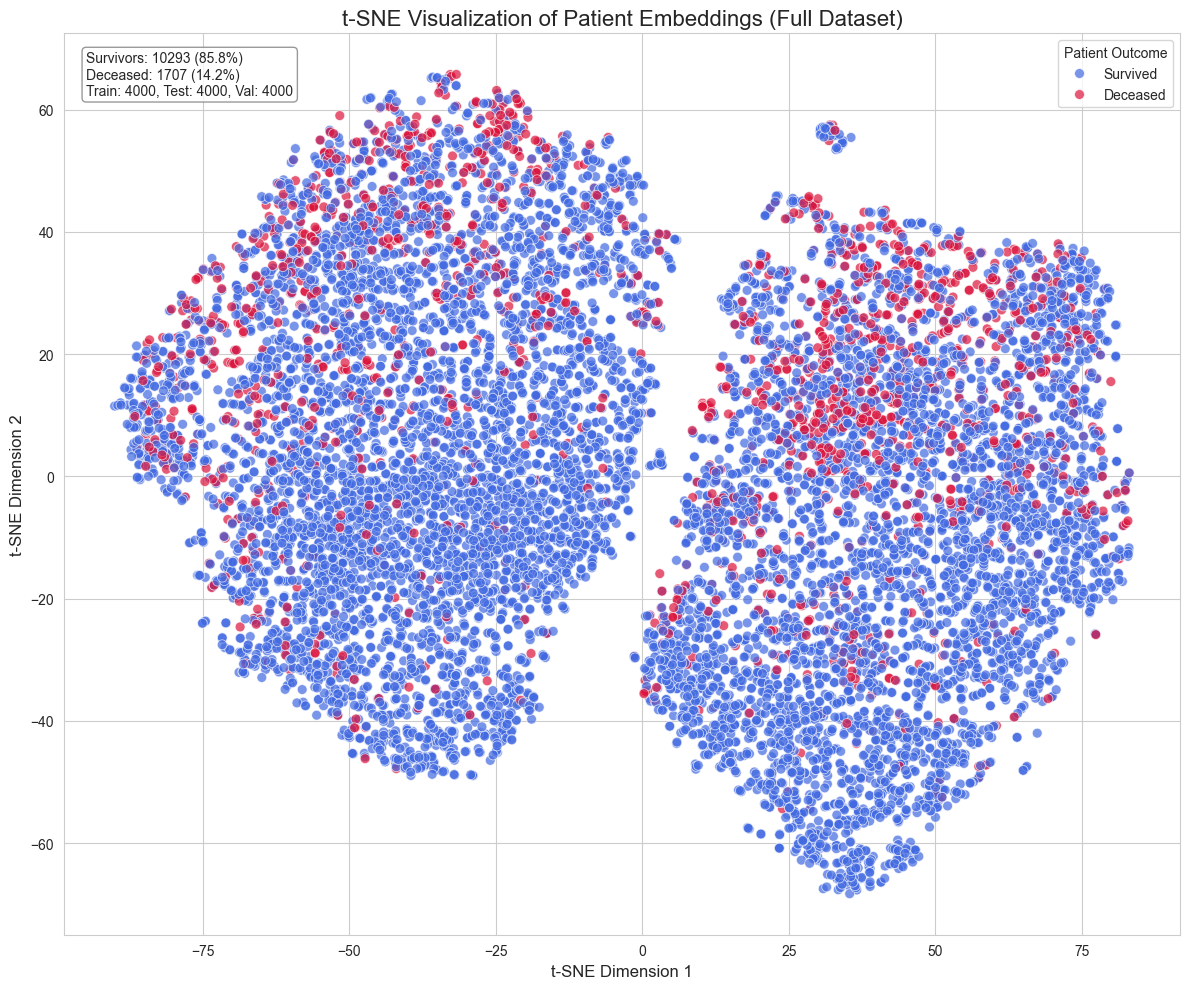

In [41]:
# Combine all sets
X_combined = torch.cat([X_train, X_test, X_val], dim=0)
if isinstance(y_train, torch.Tensor):
    y_combined = torch.cat([y_train, y_test, y_val], dim=0)
else:
    y_combined = np.concatenate([y_train, y_test, y_val])

# Create set labels to track which dataset each point came from
set_labels = np.array(['Train'] * len(X_train) + ['Test'] * len(X_test) + ['Validation'] * len(X_val))

# Convert to NumPy arrays for t-SNE
X_combined_np = X_combined.cpu().numpy()
y_combined_np = y_combined.cpu().numpy() if isinstance(y_combined, torch.Tensor) else y_combined

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_combined_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'outcome': y_combined_np,
    'dataset': set_labels
})

# Convert to category
tsne_df['outcome'] = tsne_df['outcome'].astype('category')

# Create a single plot colored by outcome
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='outcome',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings (Full Dataset)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Add statistics annotation
survivors = (y_combined_np == 0).sum()
deceased = (y_combined_np == 1).sum()
total = len(y_combined_np)

stats_text = (f'Survivors: {survivors} ({survivors/total:.1%})\n'
              f'Deceased: {deceased} ({deceased/total:.1%})\n'
              f'Train: {len(X_train)}, Test: {len(X_test)}, Val: {len(X_val)}')

plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/combined_tsne_visualization.png', dpi=300)
plt.show()

Now, we answer the question whether data points are distributed differently for different labels.

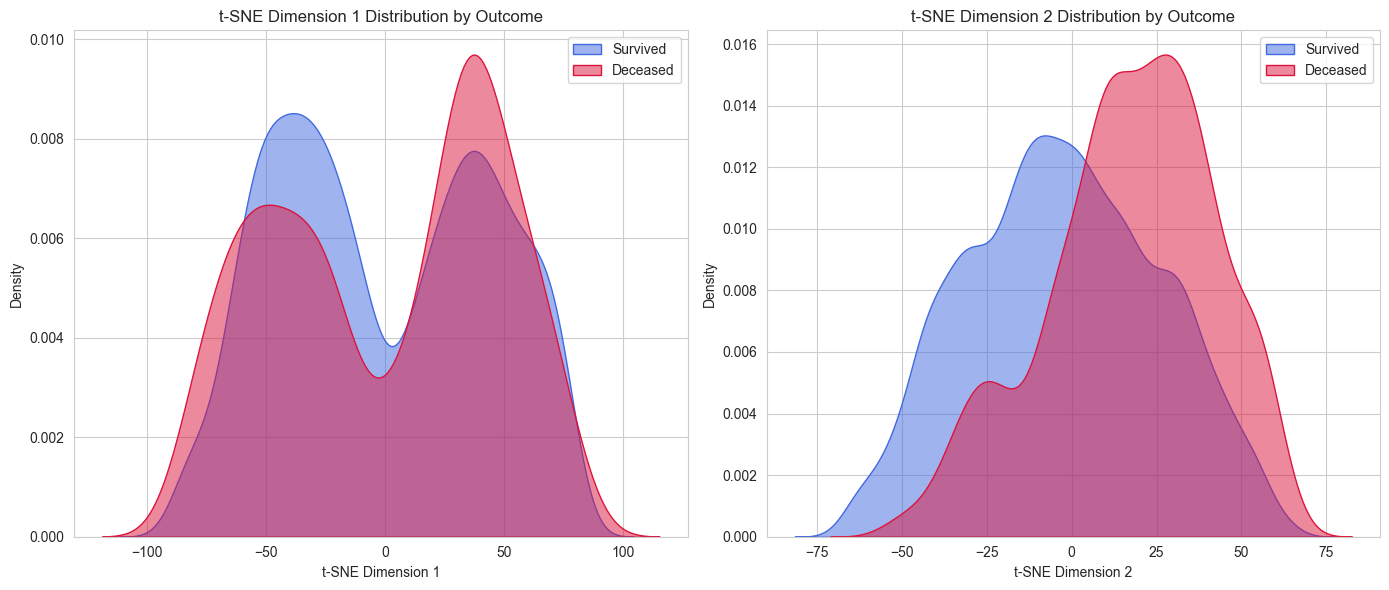

In [32]:
# Separate visualization with density plots for each class, two subplots for dimension 1 and 2
plt.figure(figsize=(14, 6))
for i, dim in enumerate(['x', 'y']):
    plt.subplot(1, 2, i+1)
    for label, color in zip([0, 1], ['royalblue', 'crimson']):
        subset = tsne_df[tsne_df['outcome'] == label]  # Changed 'label' to 'outcome'
        sns.kdeplot(subset[dim], fill=True, color=color, alpha=0.5, 
                   label='Survived' if label == 0 else 'Deceased')
    
    plt.title(f't-SNE Dimension {i+1} Distribution by Outcome')
    plt.xlabel(f't-SNE Dimension {i+1}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/tsne_density_by_class.png', dpi=300)
plt.show()

Next, we use a quantitative clustering metric to assess the quality of your dimensionality reduction w.r.t. target class labels. K-means clustering would not be well-suited as the distribution is "non-convex", so we better use UMAP.

Adjusted Rand Index: 0.0027
Normalized Mutual Information: 0.0018
Silhouette Score: 0.5083


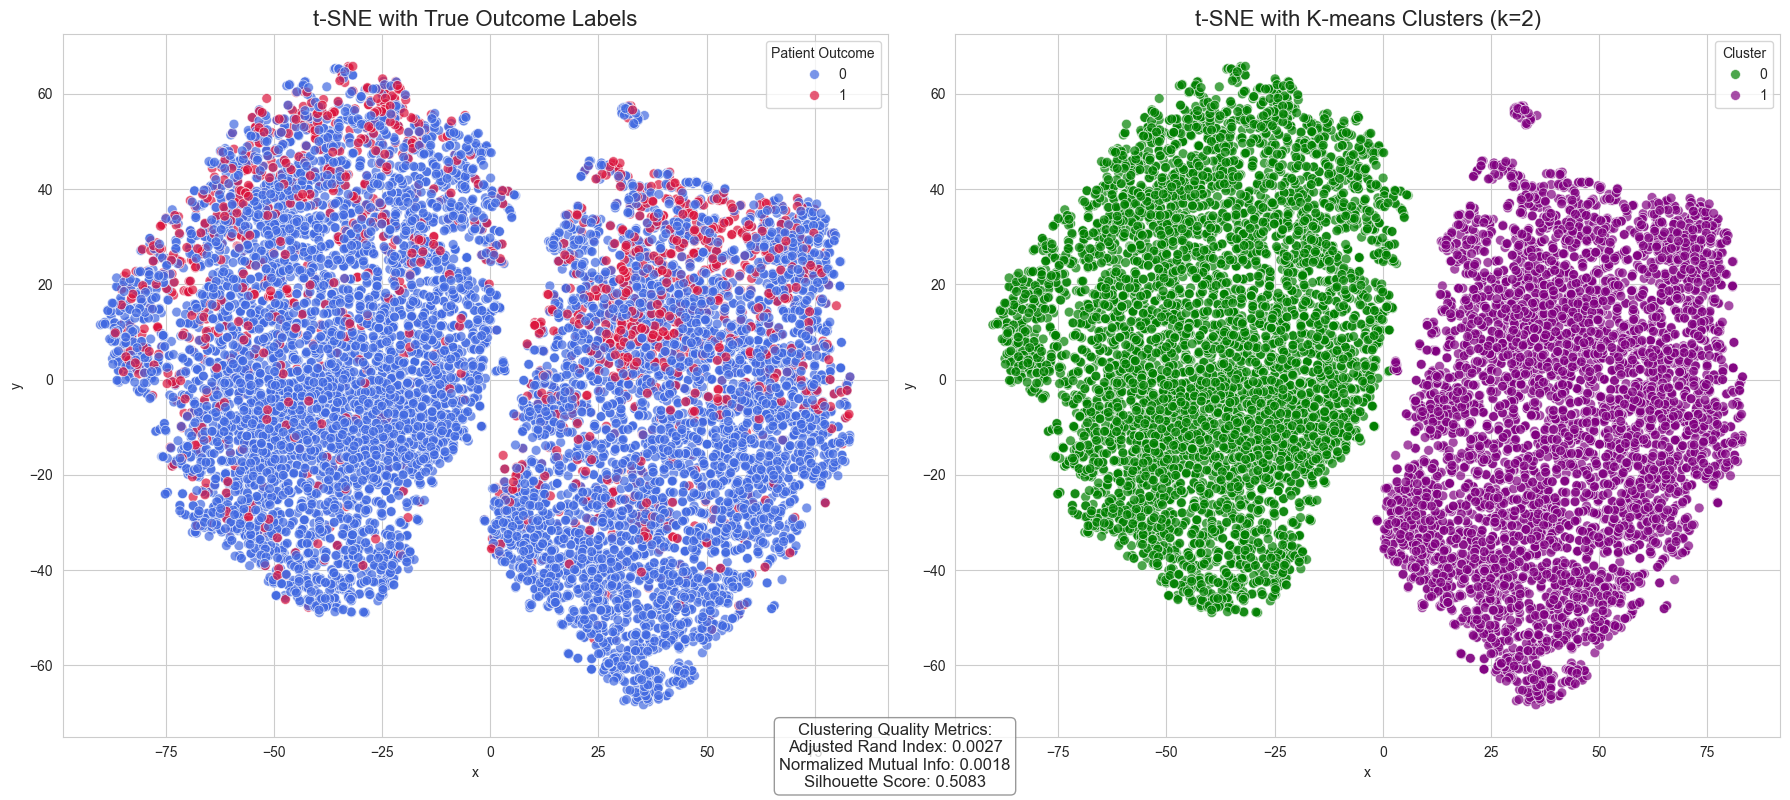

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Run k-means clustering (k=2 since we have 2 outcome classes)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_tsne)

tsne_df['cluster'] = cluster_labels
true_labels = tsne_df['outcome'].values

# Adjusted Rand Index (ARI) - measures similarity between clusterings
# Values range from -1 to 1, where 1 indicates perfect agreement
ari = adjusted_rand_score(true_labels, cluster_labels)

# Normalized Mutual Information (NMI) - measures shared information
# Values range from 0 to 1, where 1 indicates perfect correlation
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

# Silhouette score - measures how well samples are clustered
# Values range from -1 to 1, where higher values indicate better separation
silhouette = silhouette_score(X_tsne, cluster_labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: True outcome labels
sns.scatterplot(
    x='x', y='y',
    hue='outcome',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
    ax=ax1
)
ax1.set_title('t-SNE with True Outcome Labels', fontsize=16)
ax1.legend(title='Patient Outcome')

# Plot 2: K-means cluster assignments
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette={0: 'green', 1: 'purple'},
    data=tsne_df,
    alpha=0.7,
    s=50,
    ax=ax2
)
ax2.set_title('t-SNE with K-means Clusters (k=2)', fontsize=16)
ax2.legend(title='Cluster')

metrics_text = (
    f"Clustering Quality Metrics:\n"
    f"Adjusted Rand Index: {ari:.4f}\n"
    f"Normalized Mutual Info: {nmi:.4f}\n"
    f"Silhouette Score: {silhouette:.4f}"
)

plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/tsne_kmeans_evaluation.png', dpi=300)
plt.show()

We see that k-means does not perform well as the distribution is non-convex. => We visualize the patient representations of the representation / latent space in two dimensions using UMAP and analyze via 2-means in combination with hierarchical clustering: We use UMAP for dimensionality reduction, apply K-means with 10 clusters to identify local cluster centers/regions, use hierarchical clustering to merge these 10 clusters into the final 2 clusters.



